# Interface Phonon Transport (AMM and DMM)

Using the Acoustic mismatch model (AMM) and Diffusive mismatch model (DMM) to calculate the thermal conductance (G) from material A to material B.

We begin with the Landauer transport equation under the assumptions discussed previously.

$$G = \frac{1}{2} \sum_j\int_{0}^{\omega_D} \hbar \omega v_{A,j} \tau_{A\rightarrow B,j} D_{A,j}(\omega) \frac{\partial f_{BE}(T,\omega)}{\partial T}\, d\omega$$

Average transmission coefficient: $$\tau_{A\rightarrow B,j} = \int_{0}^{\pi/2} \alpha_{A\rightarrow B,j}(\theta) cos(\theta) sin(\theta) \, d\theta$$

where $\alpha_{A\rightarrow B,j}(\theta)$ is the angle dependent transmission coefficient. The AMM and DMM use different methods to calculate $\alpha_{A\rightarrow B,j}(\theta)$.

## Acoustic Mistmatch Model

In this work, we employ a simplified AMM, in which mode conversion between longitudinal and transverse phonons at the interface is neglected, and the elastic response of each medium is represented by an effective scalar acoustic impedance rather than the full tensor impedance. AMM assumes that phonons undergo specular reflection and transmission at an interface. This assumption is generally valid when the dominant phonon wavelength is much larger than the characteristic interfacial roughness. Because the phonon wavelength increases with decreasing temperature, the AMM provides a good approximation for interfacial phonon transport at low temperatures, typically on the order of ~10–100 K, depending on the materials and interface quality. At the interface, the AMM angle dependent transmission coefficient is:

$$\alpha_{A\rightarrow B,j}(\theta_A) = \frac{4Z_A Z_B}{(Z_A+Z_B)^2}$$

where $Z$ is the acoustic impedence.  Specifically,$$Z_A = \frac{\rho_A v_{A,j}}{cos(\theta_A)}$$ and $$Z_B = \frac{\rho_B v_{B,j}}{cos(\theta_B)}$$ where $v_{A,j}$ and $v_{B,j}$ are phonon group velocity of phonon mode $j$ of material A and material B. $\rho_A$ and $\rho_B$ are density of material A and material B, respectively.

To relate $\theta_A$ and $\theta_B$, we uses Snell's law which states that:
$$ \frac{sin(\theta_A)}{v_{A,j}} = \frac{sin(\theta_B)}{v_{B,j}}$$

To write this into a code:

#### Calculation for $\theta_B$

In [1]:
import numpy as np
v_A = 1; #dummy tester: speed of sound in the medium A
v_B = 1; #dummy tester: speed of sound in the medium B
theta_A = 10; # in degrees
theta_B = np.arcsin(v_B/v_A*np.sin(np.deg2rad(theta_A)));
print (np.rad2deg(theta_B))

10.0


When two materials that have the same speed of sound, the angle should not change.

#### Calculation for $\alpha_{A\rightarrow B,j}(\theta_A)$

In [2]:
rho_A = 1 #dummy tester: density of medium A
rho_B = 1 #dummy tester: density of medium B
z_A = rho_A*v_A/np.cos(np.deg2rad(theta_A)) #Acoustic imepdence of material A
z_B = rho_B*v_B/np.cos(np.deg2rad(theta_B)) #Acoustic imepdence of material B
alpha = 4*z_A*z_B/(z_A+z_B)**2 #angle dependent 
print(alpha)

0.9999414477134827


When two materials that have the same speed of sound and density, the angle dependent transmission should be 1 for all angles. 

#### Visualizing $\alpha_{A\rightarrow B,j}(\theta_A)$

Before calculating $\tau_{A\rightarrow B,j}$, let's write a function that takes in $v_A$, $v_B$, $\rho_A$, $\rho_B$, and $\theta_A$ and output $\alpha_{A\rightarrow B,j}(\theta_A)$. This will allow the integration of $\tau_{A\rightarrow B,j}$ to be simpler. 

In [3]:
def alpha_A (v_A, v_B, rho_A, rho_B, theta_A):
    theta_B = np.rad2deg(np.arcsin(v_B/v_A*np.sin(np.deg2rad(theta_A))));
    z_A = rho_A*v_A/np.cos(np.deg2rad(theta_A)) #Acoustic imepdence of material A
    z_B = rho_B*v_B/np.cos(np.deg2rad(theta_B)) #Acoustic imepdence of material B
    alpha = 4*z_A*z_B/(z_A+z_B)**2 #angle dependent 
    return alpha, theta_B

##### Case 1: $\alpha_{A\rightarrow B,j}(\theta_A)$ when two materials are the same.

Let's do some sanity checks, if $v_A$, $v_B$, $\rho_A$, $\rho_B$ are all the same, then all angle dependent transmission should be indepdent of angle and the transmission should be 1.

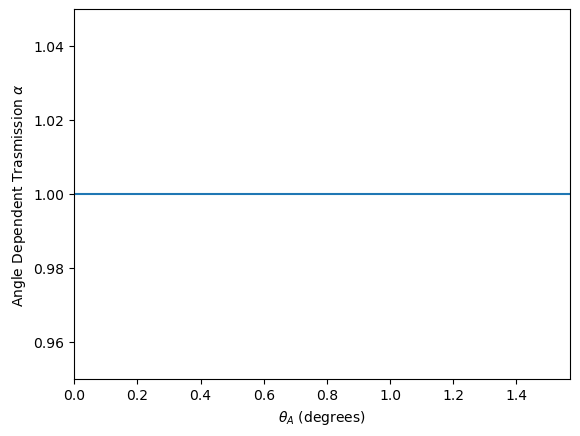

In [4]:
import matplotlib.pyplot as plt
theta_A = np.linspace(0.001,89.999,200);
v_A = 1;
v_B = 1;
rho_A = 1;
rho_B = 1;
alpha, theta_B = alpha_A(v_A, v_B, rho_A, rho_B, theta_A);
plt.plot(theta_A, alpha);plt.ylim(0.95,1.05); plt.xlim(0,np.pi/2);
plt.xlabel('$\\theta_A$ (degrees)'); plt.ylabel('Angle Dependent Trasmission $\\alpha$');

##### Case 2: $\alpha_{A\rightarrow B,j}(\theta_A)$ when $v_A\rho_A > v_B\rho_B$

When $v_A\rho_A > v_B\rho_B$, the transmission probability decreases as increasing $\theta_A$.

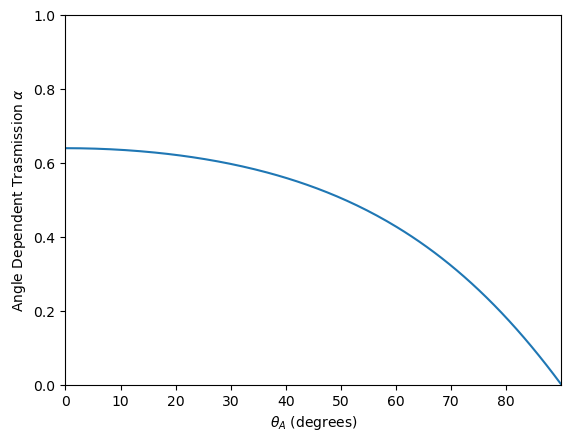

In [5]:
v_A = 2;
v_B = 1;
rho_A = 2;
rho_B = 1;
alpha, theta_B = alpha_A(v_A, v_B, rho_A, rho_B, theta_A);
plt.figure()
plt.plot(theta_A, alpha); plt.xlim(0,max(theta_A));plt.ylim(0,1)
plt.xlabel('$\\theta_A$ (degrees)'); plt.ylabel('Angle Dependent Trasmission $\\alpha$');

##### Case 3: $\alpha_{A\rightarrow B,j}(\theta_A)$ when $v_A\rho_A < v_B\rho_B$

When $v_A\rho_A < v_B\rho_B$, we have to consider the total internal reflection, otherwise $sin(\theta_B)$ will be greater than 1. The modification caps the $sin(\theta_B)$ maximum to be 1. When $sin(\theta_B)>1$, $sin(\theta_B)=1$.

In [6]:
def alpha_A (v_A, v_B, rho_A, rho_B, theta_A):
    theta_B_ratio = v_B/v_A*np.sin(np.deg2rad(theta_A));
    theta_B_ratio[theta_B_ratio > 1] = 1; # theta_B_ratio is capped at 90 degree.
    theta_B = np.rad2deg(np.arcsin(theta_B_ratio));
    z_A = rho_A*v_A/np.cos(np.deg2rad(theta_A)) #Acoustic imepdence of material A
    z_B = rho_B*v_B/np.cos(np.deg2rad(theta_B)) #Acoustic imepdence of material B
    alpha = 4*z_A*z_B/(z_A+z_B)**2 #angle dependent 
    return alpha, theta_B

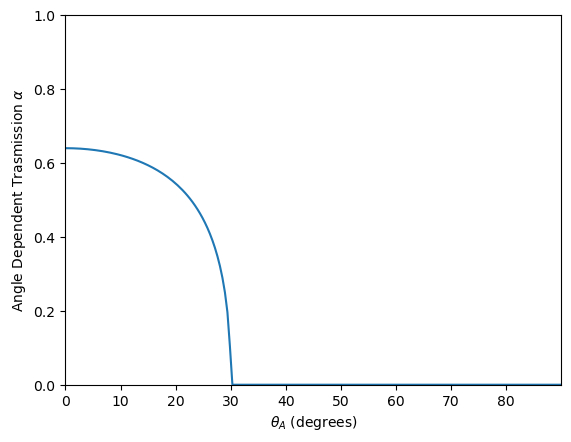

In [7]:
v_A = 1;
v_B = 2;
rho_A = 1;
rho_B = 2;
alpha, theta_B = alpha_A(v_A, v_B, rho_A, rho_B, theta_A);
plt.figure()
plt.plot(theta_A, alpha); plt.xlim(0,max(theta_A));plt.ylim(0,1);
plt.xlabel('$\\theta_A$ (degrees)'); plt.ylabel('Angle Dependent Trasmission $\\alpha$');

#### Calculation for $\tau_{A\rightarrow B,j}$

Now, we are able to calculate $\alpha_{A\rightarrow B,j}(\theta_A)$ for all cases. We can go on and calculate $\tau_{A\rightarrow B,j}$. We first will visialize $\alpha_{A\rightarrow B,j}(\theta_A) cos(\theta_A) sin(\theta_A)$.

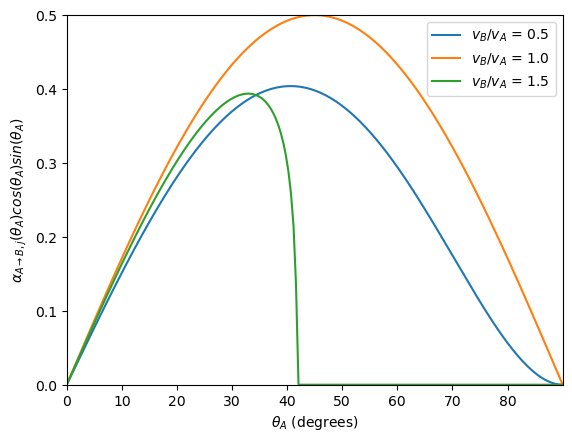

In [316]:
v_A = 1
v_B = np.array([0.5,1,1.5]);
rho_A = 1
rho_B = 1
tau_set = []
d_theta = np.deg2rad(theta_A[1])-np.deg2rad(theta_A[0]);

plt.figure()
for v_B_idx in v_B:
    ratio = v_B_idx/v_A
    alpha, _ = alpha_A(v_A, v_B_idx, rho_A, rho_B, theta_A);
    tau_theta = alpha*np.sin(np.deg2rad(theta_A))*np.cos(np.deg2rad(theta_A));
    tau_set.append(sum(tau_theta*d_theta));
    plt.plot(theta_A,tau_theta, label = f'$v_B/v_A$ = {ratio}')
plt.legend();plt.xlim(0,max(theta_A));plt.ylim(0,0.5);
plt.xlabel('$\\theta_A$ (degrees)');
plt.ylabel('$\\alpha_{A\\rightarrow B,j}(\\theta_A) cos(\\theta_A) sin(\\theta_A)$');

By looking at the $\alpha_{A\rightarrow B,j}(\theta_A) cos(\theta_A) sin(\theta_A)$, $\tau_{A\rightarrow B,j}$ should be the largest when $v_B/v_A = 1$ and smallest when $v_B/v_A = 1.5$ due to total interal refraction. The maximum $\alpha_{A\rightarrow B,j}(\theta_A) cos(\theta_A) sin(\theta_A)$ is 0.5 for $v_b/v_A = 1$.

print $\tau_{A\rightarrow B,j}$:

In [9]:
print(v_B/v_A)
print(tau_set)

[0.5 1.  1.5]
[0.37036581584469414, 0.4999897534548613, 0.18974768712956017]


To better visualize the impact of $v_B/v_A$ and $\rho_B/\rho_A$ on $\tau_{A\rightarrow B,j}$, we can produce a 2D map. We will first create a function that takes the input of $v_A$, $v_B$, $\rho_A$, $\rho_B$ and produce the output of $\tau_{A\rightarrow B,j}$. 

In [10]:
def tau(v_A, v_B, rho_A, rho_B):
    theta_A = np.linspace(0.001,89.999,200);
    alpha, _ = alpha_A(v_A, v_B, rho_A, rho_B, theta_A);
    tau_theta = alpha*np.sin(np.deg2rad(theta_A))*np.cos(np.deg2rad(theta_A));
    return sum(tau_theta*d_theta)

v_A = 1;
v_B_array = np.logspace(-1,1,100);
rho_A = 1;
rho_B_array = np.logspace(-1,1,100);

tau_map = np.zeros([len(v_B_array),len(rho_B_array)])

for row in range(len(v_B_array)):
    for col in range(len(rho_B_array)):
        tau_map[row,col] = tau(v_A, v_B_array[row], rho_A, rho_B_array[col])

The results should reproduce Figure 1 of Little's work, "The transport of heat between dissimilar solids at low temperature" Can. J. Phys. Vol. 37 (1959). 

Text(0.5, 1.0, '$\\tau_{A\\rightarrow B,j}$')

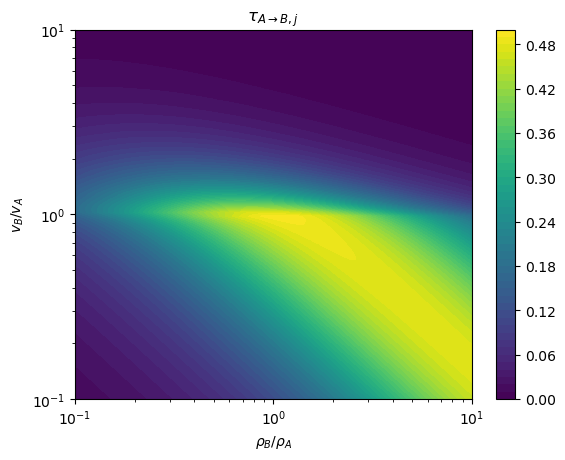

In [11]:
plt.contourf(rho_B_array, v_B_array, tau_map,levels=50,);plt.colorbar();
plt.xscale('log');
plt.yscale('log');
plt.xlabel('$\\rho_B/\\rho_A$');
plt.ylabel('$v_B/v_A$');
plt.title('$\\tau_{A\\rightarrow B,j}$')

### Calculation for Thermal Boundary Conductance using AMM

Since the average transmission coefficient ($\tau_{A\rightarrow B,j}$) and phonon propagation velocity ($v_{A,j}$) is assumed to be independent to the phonon frequency ($\omega$), the previous thermal boundary conductance ($G$) equation simplifies to:

$$G = \frac{1}{2}  \sum_j v_{A,j} \tau_{A\rightarrow B,j} \int_{0}^{\omega_D} \hbar \omega D_{A,j}(\omega) \frac{\partial f_{BE}(T,\omega)}{\partial T}\, d\omega$$

Under Debye's assumption of linear phonon dispersion, the phonon density of state ($D_{A,j}(\omega)$) is:

$$D_{A,j}(\omega) = \frac{\omega^2}{2\pi^2v_{A,j}^3}$$

Thus, $G$ simplifies to:
$$G = \frac{1}{4\pi^2}\left[\frac{\tau_{A\rightarrow B,l}}{v_{A,l}^2}+\frac{2\tau_{A\rightarrow B,t}}{v_{A,t}^2}\right]\int_{0}^{\omega_D} \hbar \omega^3 \frac{\partial f_{BE}(T,\omega)}{\partial T}\, d\omega$$

Here, we are assuming that there are one longitudinal and two transverse phonon modes. Each mode has an unique $\tau_{A\rightarrow B}$ and $v_A$.

We use Bose-Einstein distribution for the phonons which does not obey Pauli exclusion principles. The Bose-Einstein distribution is:

$$f_{BE}(T,\omega)=\frac{1}{e^{\frac{\hbar \omega}{k_B T}}-1} $$

Thus,

$$\frac{\partial f_{BE}(T,\omega)}{\partial T} = \frac{\hbar \omega}{k_B T^2}\frac{e^{\frac{\hbar \omega}{k_B T}}}{(e^{\frac{\hbar \omega}{k_B T}}-1)^2}$$

To improve numerical stability, we introduce the dimensionless variable $x$ for $\frac{\hbar \omega}{k_B T}$. This substitution improves numerical stability, because it rescales the integration variable to be dimensionless and of order unity near the dominant contribution.

$$G = \frac{k_B^4 T^3}{4\pi^2 \hbar^3}\left[\frac{\tau_{A\rightarrow B,l}}{v_{A,l}^2}+\frac{2\tau_{A\rightarrow B,t}}{v_{A,t}^2}\right]\int_{0}^{x_D} x^4\frac{e^x}{(e^x-1)^2}\, dx$$

There are two important observations:
1. The integral is unitless. Thus, $G$ is positively correlated with $T^3$.
2. When $T << \Theta_D$, $x_D \rightarrow \infty$, the integral has a solution of $\frac{4}{15}\pi^4$:
$$G = \frac{\pi^2 k_B^4 T^3}{15 \hbar^3}\left[\frac{\tau_{A\rightarrow B,l}}{v_{A,l}^2}+\frac{2\tau_{A\rightarrow B,t}}{v_{A,t}^2}\right]$$

At low temperature which is the applicable regime of AMM, the $G$ is only dependent on the $v_A$, $v_B$, $\rho_A$, $\rho_B$, and $T$. However, at ultralow temperature ($T<1K$), the AMM model underestimates $G$, for more detail refer to the review paper: Reviews of Modern Physics, Vol. 61, No. 3, July 1989.

To visualize this equation, we will examin two sets of materials: Quartz / Gold and Sapphire / Gold. 

In [12]:
import pandas as pd

data = {
    "material": ["gold", "quartz", "sapphire","silicon"],
    "density": [19300, 2660, 3970, 2330],
    "v_l": [3.39*10**3, 6.09*10**3, 10.89*10**3, 8.97*10**3],
    "v_t": [1.29*10**3, 4.10*10**3, 6.45*10**3, 5.332*10**3]
}
df = pd.DataFrame(data);
df

,material,density,v_l,v_t
0,gold,19300,3390.0,1290.0
1,quartz,2660,6090.0,4100.0
2,sapphire,3970,10890.0,6450.0
3,silicon,2330,8970.0,5332.0


Here, we are creating a database that contains material properties that we inputted from our database. Not important for the phonon transport. 

In [13]:
class Material:
    def __init__(self, name, density, v_l, v_t):
        self.name = name;
        self.density = density;
        self.v_l = v_l;
        self.v_t = v_t;
    
    def name (self):
        return self.name
    
    def density(self):
        return self.density
    
    def v_l (self):
        return self.v_l
    
    def v_t (self):
        return self.v_t
    
    def __repr__(self):
        return f"Material(name={self.name}, density={self.density}, v_l={self.v_l}, v_t={self.v_t})"
    
class MaterialDB:
    def __init__(self, df):
        # Create a dictionary mapping lowercase names → Material objects
        self.materials = {}
        for _, row in df.iterrows():
            name = row["material"].lower()
            mat = Material(
                name=row["material"],
                density=row["density"],
                v_l=row["v_l"],
                v_t=row["v_t"]
            )
            self.materials[name] = mat

    def get(self, name):
        return self.materials[name.lower()]   # case-insensitive

In [14]:
db = MaterialDB(df)

gold = db.get("gold") 
sapphire = db.get("sapphire")
quartz = db.get("quartz")
silicon = db.get("silicon")

Here are two essential functions. tau_AMM calculates $\tau_{A\rightarrow B}$ and g_AMM calculates the interfacial thermal conductance ($G$).

In [335]:
def tau_AMM(v_A, v_B, rho_A, rho_B):
    theta_A = np.linspace(0,90,10000);
    d_theta = np.deg2rad(theta_A[1]-theta_A[0])
    alpha, _ = alpha_A(v_A, v_B, rho_A, rho_B, theta_A);
    tau_theta = alpha*np.sin(np.deg2rad(theta_A))*np.cos(np.deg2rad(theta_A));
    return sum(tau_theta*d_theta)

def g_AMM(v_l_A, v_l_B, v_t_A, v_t_B, rho_A, rho_B, T):
    tau_t = tau_AMM(v_t_A,v_t_B, rho_A, rho_B);
    tau_l = tau_AMM(v_l_A,v_l_B, rho_A, rho_B);
    
    h_bar = 1.054571817e-34;
    kB = 1.380649e-23;
    
    constant = np.pi**2*kB**4*T**3/(15*h_bar**3);
    
    g = constant*(tau_l/v_l_A**2+2*tau_t/v_t_A**2);
    
    return g

#### AMM Thermal Boundary Conductance:

One common way to show the thermal boundary conductance is to show the T independent terms:

$$\frac{G}{T^3} = \frac{\pi^2 k_B^4}{15 \hbar^3}\left[\frac{\tau_{A\rightarrow B,l}}{v_{A,l}^2}+\frac{2\tau_{A\rightarrow B,t}}{v_{A,t}^2}\right]$$

###### Gold to Sapphire Interface

In [336]:
T = 10; # Kelvin
g_go_sa= g_AMM(gold.v_l, sapphire.v_l, gold.v_t, sapphire.v_t, gold.density, sapphire.density,T)
g_go_sa_T = g_go_sa/T**3;
print(f"Gold to sapphire interface: {g_go_sa_T:.2f} W/m^2/K^4")

Gold to sapphire interface: 526.39 W/m^2/K^4


###### Sapphire to Gold Interface

In [337]:
g_sa_go= g_AMM(sapphire.v_l, gold.v_l, sapphire.v_t, gold.v_t, sapphire.density, gold.density, T)
g_sa_go_T = g_sa_go/T**3;
print(f"Sapphire to gold interface: {g_sa_go_T:.2f} W/m^2/K^4")

Sapphire to gold interface: 526.40 W/m^2/K^4


This is super interesting! When we switched the material around, the $G$ does not change. We will discuss this in future due to limited time. 

###### Gold to Quartz Interface

In [338]:
g_go_qz= g_AMM(gold.v_l, quartz.v_l, gold.v_t, quartz.v_t, gold.density, quartz.density,T)
g_go_qz_T = g_go_qz/T**3;
print(f"Gold to Quartz interface: {g_go_qz_T:.2f} W/m^2/K^4")

Gold to Quartz interface: 1327.14 W/m^2/K^4


###### Gold to Silicon Interface

In [339]:
g_go_si= g_AMM(gold.v_l, silicon.v_l, gold.v_t, silicon.v_t, gold.density, silicon.density,T)
g_go_si_T = g_go_si/T**3;
print(f"Gold to Silicon interface: {g_go_si_T:.2f} W/m^2/K^4")

Gold to Silicon interface: 780.96 W/m^2/K^4


Existing literature often shows thermal boundary resistance ($R$) rather than G. To compare wit the existing literature, we can write show $R T^3$. The result is not exactly the same but similar to the existing literature (Rev. Mod. Phys., Vol. 61, No. 3, July 1989). However, all the calculated numbers are within a reasonable range. 

In [342]:
print(f"Gold to sapphire interface: {1/g_go_sa_T*10**4:.2f} K^4 cm^2/W; Literature: 18.9 K^4 cm^2/W")
print(f"Gold to quartz interface: {1/g_go_qz_T*10**4:.2f} K^4 cm^2/W; Literature: 8.12 K^4 cm^2/W")
print(f"Gold to silicon interface: {1/g_go_si_T*10**4:.2f} K^4 cm^2/W; Literature: 15.8 K^4 cm^2/W")

Gold to sapphire interface: 19.00 K^4 cm^2/W; Literature: 18.9 K^4 cm^2/W
Gold to quartz interface: 7.53 K^4 cm^2/W; Literature: 8.12 K^4 cm^2/W
Gold to silicon interface: 12.80 K^4 cm^2/W; Literature: 15.8 K^4 cm^2/W


## Diffuse Mismatch Model

Differ from AMM model, DMM is a diffuse scattering event. This implies that the dominant phonon wavelength becomes comparable to the physical roughness of the interface. Because the characteristic phonon wavelength decreases with increasing temperature, high-temperature heat transport is dominated by short-wavelength phonons that experience strong diffuse scattering from atomic-scale roughness. As a result, DMM provides a good approximation for interfacial thermal transport in this regime. This means that the phonon loss its memory in where it came form and which mode it came from. In contrast from the AMM model, for DMM model, $\alpha_{A\rightarrow B,j}$ is not a function of $\theta_A$ and cannot be calculated besides that we know the sum of reflection and transmission has to be 1, assuming no absorption.Further, since we loss track of the polarization $\alpha_{A\rightarrow B,j}$ becomes $\alpha_{A\rightarrow B}$

$$\alpha_{A\rightarrow B} = 1 - \alpha_{B\rightarrow A}$$

Thus, the total energy carried by phonon that leaving from A to B must equal to the total energy carrier by phonon leaving from B to A (balance of energy flux). 

$$\sum_{j}v_{A,j}D_{A,j} f_{BE} \alpha_{A\rightarrow B} = \sum_{j}v_{B,j}D_{B,j} f_{BE} (1-\alpha_{A\rightarrow B})$$

We can solve for $\alpha_{A\rightarrow B}$:
$$\alpha_{A\rightarrow B} = \frac{ \sum_{j}v_{B,j}D_{B,j} f_{BE}}{ \sum_{j}v_{B,j}D_{B,j} f_{BE}+\sum_{j}v_{A,j}D_{A,j} f_{BE}}$$

In the Debye model, the only difference in the density of state between material A and material B is the phonon group velocity.
We can solve for $\alpha_{A\rightarrow B}$:
$$\alpha_{A\rightarrow B} = \frac{ \sum_{j} v_{B,j}^{-2}}{ \sum_{j}v_{B,j}^{-2}+\sum_{j}v_{A,j}^{-2}}$$

Since $\alpha_{A\rightarrow B}$ is independent of $\theta_{A}$, so the angle integral becomes 1/2: $$\tau_{A\rightarrow B} = \frac{1}{2}\frac{ \sum_{j} v_{B,j}^{-2}}{ \sum_{j}v_{B,j}^{-2}+\sum_{j}v_{A,j}^{-2}}$$

To calculate the conductance at a higher temperature, we have to numerically solve this integral:
$$G = \frac{1}{2} \tau_{A\rightarrow B} \sum_j v_{A,j} \int_{0}^{\omega_D} \hbar \omega D_{A,j}(\omega) \frac{\partial f_{BE}(T,\omega)}{\partial T}\, d\omega$$

so we will need three functions: 1. transmission calculation. 2. density of states. 3. Bose-Einsten distribution derivative. However, for numerical accuracy, we cannot directly solve this equation as the span of $\omega$ is very large. Thus, we need to normalized variable, $x = \hbar\omega / k_{B}T$. $x$ will have a much narrow span to reduce the numerical error. 

$$G = \frac{\tau_{A\rightarrow B}k_B^4 T^3}{4\pi^2 \hbar^3}\sum_j \frac{1}{v_{A,j}^2}\int_{0}^{x_D} x^4\frac{e^x}{(e^x-1)^2}\, dx$$

using the assumptions that we made earlier, this equation simplifies to:

$$G= \frac{\tau_{A\rightarrow B}k_B^4 T^3}{4\pi^2 \hbar^3}\left[\frac{1}{v_{A,l}^2}+\frac{2}{v_{A,t}^2}\right]\int_{0}^{x_D} x^4\frac{e^x}{(e^x-1)^2}\, dx$$

In [21]:
h_bar = 1.054571817e-34;
kB = 1.380649e-23;
T_debye = 500; #Kelvin


In [35]:
def tau_DMM(v_l_A, v_l_B, v_t_A, v_t_B):
    v_A_sum = 1/v_l_A**2 + 2/v_t_A**2;
    v_B_sum = 1/v_l_B**2 + 2/v_t_B**2;
    tau = 1/2*v_B_sum / (v_A_sum + v_B_sum)
    return tau

def int_DOS_fBE (T, T_debye, points = 1000):
    omega_debye = kB*T_debye/h_bar
    x_d = h_bar * omega_debye / (kB*T);
    x = np.linspace(10**(-6),x_d,points);
    dx = x[1]-x[0]
    int_inside = x**4*np.exp(x)/(np.exp(x)-1)**2
    return sum(int_inside*dx)

def g_DMM_Tind (v_l_A, v_l_B, v_t_A, v_t_B, T_debye, T, points):
    tau = tau_DMM(v_l_A, v_l_B, v_t_A, v_t_B);
    integral = int_DOS_fBE (T, T_debye, points = points);
    g_constant = tau*kB**4/(4*np.pi**2*h_bar**3);
    g_Tind = g_constant*(1/v_l_A**2+2/v_t_A**2)*integral;
    return g_Tind

###### Gold to Sapphire Interface

In [287]:
T = 10
g_go_sa= g_DMM_Tind(gold.v_l, sapphire.v_l, gold.v_t, sapphire.v_t, T_debye, T, 1000)
print(f"Gold to sapphire interface: {g_go_sa:.2f} W/m^2/K^4")

Gold to sapphire interface: 551.75 W/m^2/K^4


###### Gold to Quartz Interface

In [288]:
g_go_qz= g_DMM_Tind(gold.v_l, quartz.v_l, gold.v_t, quartz.v_t, T_debye, T, 1000)
print(f"Gold to Quartz interface: {g_go_qz:.2f} W/m^2/K^4")

Gold to Quartz interface: 1336.20 W/m^2/K^4


###### Gold to Quartz Interface

In [51]:
g_go_si= g_DMM_Tind(gold.v_l, silicon.v_l, gold.v_t, silicon.v_t, T_debye, T, 1000)
print(f"Gold to Silicon interface: {g_go_si:.2f} W/m^2/K^4")

Gold to Silicon interface: 792.78 W/m^2/K^4


In contrast from AMM, DMM can be used at high temperature. Thus, it is no longer appropriate to simply assume that $T << \Theta_D$, $x_D \rightarrow \infty$, we will have to solve the integral for each temperature.

In [90]:
def g_DMM (v_l_A, v_l_B, v_t_A, v_t_B, T_debye, T_arr, points):
    tau = tau_DMM(v_l_A, v_l_B, v_t_A, v_t_B);
    integral = int_DOS_fBE (T_arr, T_debye, points = points);
    g_constant = tau*kB**4/(4*np.pi**2*h_bar**3)*T_arr**3;
    g = g_constant*(1/v_l_A**2+2/v_t_A**2)*integral;
    return g

In [106]:
T_arr = np.logspace(1,3,100);
g_go_sa_arr= g_DMM(gold.v_l, sapphire.v_l, gold.v_t, sapphire.v_t, T_debye, T_arr, 1000)

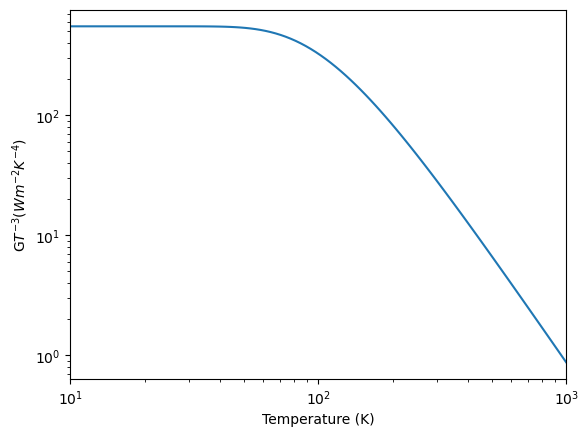

In [120]:
plt.plot(T_arr, g_go_sa_arr/T_arr**3);
plt.xlim(min(T_arr),max(T_arr));
plt.xscale('log');
plt.yscale('log');
plt.xlabel('Temperature (K)');
plt.ylabel('G$T^{-3} (W m^{-2} K^{-4})$');

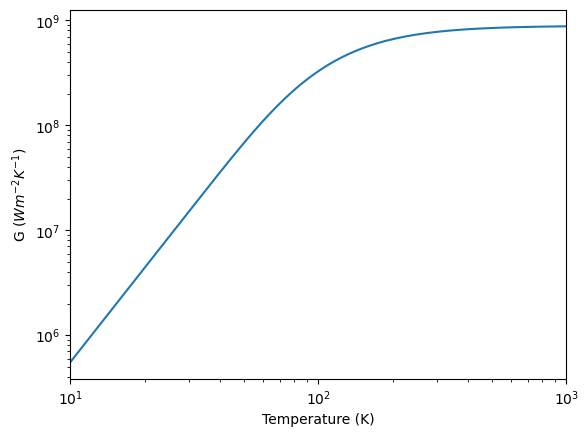

In [119]:
plt.plot(T_arr, g_go_sa_arr);
plt.xlim(min(T_arr),max(T_arr));
plt.xscale('log');
plt.yscale('log');
plt.xlabel('Temperature (K)');
plt.ylabel('G $(W m^{-2} K^{-1})$');

Based on our current calculation and assumptions, the only difference between AMM and DMM thermal boundary conductance is the transmission probability. However, the resultant solid-to-solid interface thermal boundary conductance is almost no difference. Thus, a question arises, when does AMM and DMM becomes different?

## Difference between AMM and DMM

A method to compare AMM and DMM model is to compare the transmission as a function of material phonon group velocity dissimilarities. Let's assume material A is gold and material B's phonon group velocity can be varied and the density on the bothslides are the same.

In [311]:
dissimilarity = np.logspace(-.7,0.7,100); # Range of the dissimilarities
m_A_l = gold.v_l;
m_A_t = gold.v_t;
m_B_l = dissimilarity * m_A_l;
m_B_t = dissimilarity * m_A_t;
density_ratio = gold.density

In [312]:
def tau_DMM_comb (v_l_A, v_l_B, v_t_A, v_t_B):
    tau = tau_DMM(v_l_A, v_l_B, v_t_A, v_t_B);
    tau_DMM_comb = tau*(1/v_l_A**2+2/v_t_A**2);
    return tau_DMM_comb

In [313]:
def tau_AMM_comb(v_l_A, v_l_B, v_t_A, v_t_B, rho_A, rho_B):
    tau_t = tau_AMM(v_t_A,v_t_B, rho_A, rho_B);
    tau_l = tau_AMM(v_l_A,v_l_B, rho_A, rho_B);

    tau_AMM_comb  = tau_l/v_l_A**2+2*tau_t/v_t_A**2;
    
    return tau_AMM_comb

In [314]:
g_ratio = []
for n in range(len(m_B_l)):
    tau_dmm = tau_DMM_comb(m_A_l, m_B_l[n], m_A_t, m_B_t[n]);
    tau_amm = tau_AMM_comb(m_A_l, m_B_l[n], m_A_t, m_B_t[n], gold.density, density_ratio);
    g_ratio.append(tau_dmm/tau_amm)

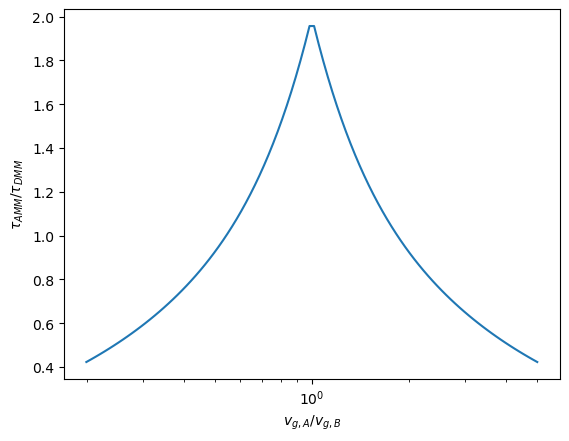

In [344]:
plt.plot(m_A_l/m_B_l,1/np.array(g_ratio));
plt.xlabel('$v_{g,A} / v_{g,B}$');
plt.ylabel('$\\tau_{AMM} / \\tau_{DMM}$');
plt.xscale('log')

This result shows that when two materials are very similar, the $\tau_{AMM} > \tau_{DMM}$. However, whenever the group velocity varies dramatically, $\tau_{AMM} < \tau_{DMM}$. For most of the solid-solid interfaces, the phonon group velocity is similar, resuling a similar transmission for either AMM and DMM. 